In [1]:
import sys
#sys.path.append("/home/zoe/anaconda3/envs/arctic/lib/python3.6/site-packages/")
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy as c
from mpl_toolkits import mplot3d
from gsw import SA_from_SP
from gsw import CT_from_t
from gsw import rho
from gsw import alpha
import os
import gsw
import xarray as xr
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.io as io

In [2]:
# Path to ITPs data and topography in the Canada basin file (.mat from NOAA)
path='/Users/zcaspar/Documents/Stage/ITP/'
file_topo='/Users/zcaspar/Documents/Stage/grl/Topo/etopo4.mat'


In [3]:
#Functions 
def topography(topo_file):
    """ Read topography file and returns latitude, longitude and depth
    """
    f=io.loadmat(topo_file)
    lat=f['etopo360'][0][0][0]
    lon=f['etopo360'][0][0][1]
    topo=f['etopo360'][0][0][2]
    # Read data from: http://coastwatch.pfeg.noaa.gov/erddap/griddap/usgsCeSrtm30v6.html
    return lat,lon,topo

In [4]:
#Année de campagnes à utiliser :
year='2006'

### Select data from cruises for needed years (and at the moorings)

In [5]:
import locale,re,seawater
locale.setlocale(locale.LC_ALL,'en_US')
def readHydrographicSurvey(rootFolder='/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/1db_down/'):
 
    files =np. sort(glob.glob(rootFolder+'d*.cnv'))
    data = []
    n = 0
    for i,f in enumerate(files):
        print (f)
        for line in open(f,'rb').readlines():
            if b'Latitude' in line:
            #lat =  line[18:-4].split(' ');  lat =  float(lat[0]) + float(lat[1])/60. 
                lat =  [int(s) for s in re.split(b"[^0-9]",line) if s.isdigit()];  lat =  float(lat[0]) + float(lat[1]+lat[2]/100.)/60. 
            if b'Longitude' in line:
            #lon =  line[19:-4].split(' '); lon = -float(lon[0]) + float(lon[1])/60. 
                lon =  [int(s) for s in re.split(b"[^0-9]",line) if s.isdigit()];  lon = -float(lon[0]) + float(lon[1]+lon[2]/100.)/60. 
            if b'= prDM:' in line:
                pressureCol = int(line.split(b' ')[2])
    #      if b'= depSM:' in line:
    #        depthCol = int(line.split(b' ')[2])
            if b'= t090C:' in line:
                tempCol = int(line.split(b' ')[2])
            if b'= sal00:' in line:
                saltCol = int(line.split(b' ')[2])
            if b'= potemp090C:' in line:
                potempCol = int(line.split(b' ')[2])
            if (b'NMEA UTC' in line) | (b'UTC (Time):' in line):
                match = re.search(rb'.{3} \d{2} \d{4} *\d{2}:\d{2}:\d{2}', line)
                date = datetime.datetime.strptime(match.group().decode("utf-8"), '%b %d %Y  %H:%M:%S')
                print (date)
            if b'nvalues' in line:
                nvalues = re.search(rb'\d+',line).group()



        if (int(nvalues) > 2) | (nvalues==None):  
    #      pressure,depth,temperature,salinity,pottemp = loadtxt(f,comments=['#','*'],usecols=(pressureCol,depthCol,tempCol,saltCol,potempCol),encoding='latin1',unpack=True)
            pressure,temperature,salinity,pottemp = np.loadtxt(f,comments=['#','*'],usecols=(pressureCol,tempCol,saltCol,potempCol),encoding='latin1',unpack=True)  
            rho = seawater.dens(salinity,temperature,pressure)
            rho0 = seawater.pden(salinity,temperature,pressure)
            N2,q,p_ave  = seawater.bfrq(salinity,temperature,pressure,lat)

            data.append(

             xr.Dataset(

              data_vars={

                'salt'                        : (['time','pressure'],[salinity]),   

                'temp'                        : (['time','pressure'],[temperature]),

                'rho'                         : (['time','pressure'],[rho]),        

                'rho0'                        : (['time','pressure'],[rho0]),       

                'N2'                          : (['time','pressureN2'],N2.T),

                'planetaryPotentialVorticity' : (['time','pressureN2'],q.T),

                'pottemp'                     : (['time','pressure'],[pottemp]),

                },

              coords={

                'lat':(['time'],[lat]),

                'lon':(['time'],[lon]),

    #            'depth':(['time','pressure'],[depth]),

                'time':[date],

                'pressure':pressure,

                'pressureN2':p_ave[:,0],

                'num':n,

                }

              )

              )

    n+=1

    casts = xr.concat(data,dim='time').sortby('time')
  


    return casts 

In [6]:
import glob,datetime
casts = readHydrographicSurvey(rootFolder='/Users/zcaspar/Documents/Stage/grl/data_ctd/%s/'%year)

#%%

  # latitude and longitude of the mooring
latAMooring,lonAMooring = 75,-150
latBMooring,lonBMooring = 78,-150
latCMooring,lonCMooring = 77,-140
latDMooring,lonDMooring = 74,-140



# select all mooring withing dlon and dlat degrees from the mooring
casts_int = casts.where((casts.lon>-161)&(casts.lat>72)&(casts.lon<-130)&(casts.lat<80)
                        ,drop=True)

#castsAtMooring = casts.where(  ( abs(casts.lat-latAMooring) < dlon ) & ( abs(casts.lon-lonAMooring) < dlat ), drop=True  )
#castsBtMooring = casts.where(  ( abs(casts.lat-latBMooring) < dlon ) & ( abs(casts.lon-lonBMooring) < dlat ), drop=True  )
#castsCtMooring = casts.where(  ( abs(casts.lat-latCMooring) < dlon ) & ( abs(casts.lon-lonCMooring) < dlat ), drop=True  )
#castsDtMooring = casts.where(  ( abs(casts.lat-latDMooring) < dlon ) & ( abs(casts.lon-lonDMooring) < dlat ), drop=True  )

/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_001.cnv
2006-07-29 12:41:17
/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_002.cnv
2006-07-29 17:18:17
/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_003.cnv
2006-07-29 23:04:01
/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_004.cnv
2006-07-30 12:52:47
/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_005.cnv
2006-07-30 17:15:43
/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_006.cnv
2006-07-30 19:03:07
/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_007.cnv
2006-07-31 12:46:15
/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_008.cnv
2006-08-02 04:51:29
/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_009.cnv
2006-08-02 07:47:21
/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_010.cnv
2006-08-04 14:50:51
/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_011.cnv
2006-08-07 17:58:53
/Users/zcaspar/Documents/Stage/grl/data_ctd/2006/d200618_012.cnv


In [7]:
casts_int = casts_int.sortby('time')

Text(1355697.7568962714, 403068.5468360316, '50')

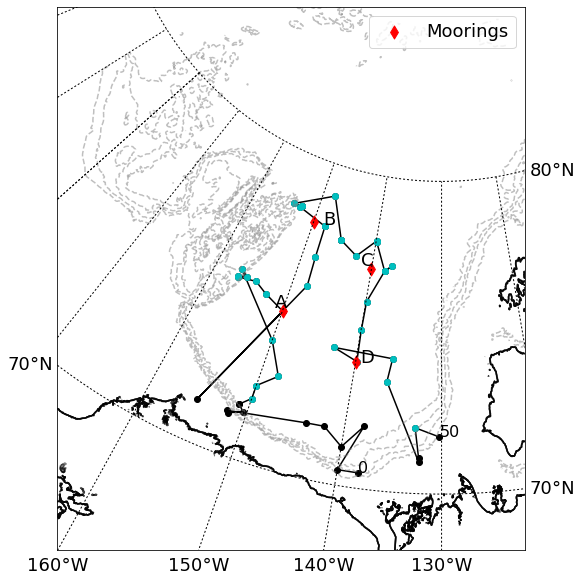

In [8]:
mapcolor=cm.RdYlBu_r
Size=18
i0 = 13
mpl.rcParams['legend.fontsize']=Size
fig = plt.figure(figsize=(15, 10) ) 

#Create map from Basemap
m = Basemap(width=6000000,height=4500000,resolution='c',projection='aea',lon_0=-130,lat_0=75,llcrnrlon=-160.,llcrnrlat=65.,urcrnrlon=-100.,urcrnrlat=85.)
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,10.),labels=[True,True,False,False],dashes=[2,2],fontsize=Size)
m.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[2,2],fontsize=Size)

#Add bathymetry
lat_t,lon_t,topo=topography(file_topo)
lon_topo,lat_topo=np.meshgrid(lon_t,lat_t)
Lon_topo,Lat_topo=m(lon_topo,lat_topo)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(-2000,0,500),colors='gray',alpha=0.5)
m.contour(Lon_topo,Lat_topo,topo,levels=np.arange(10,15,1),colors='k',alpha=0.5)

m.plot(casts.isel(time=slice(i0,None)).lon.values,casts.isel(time=slice(i0,None)).lat.values
       ,c='k',marker='o',latlon=True,zorder=-1)
m.scatter(casts_int.lon.values,casts_int.lat.values,c='c',marker='o',latlon=True,zorder=0)

#Add locations of the moorings A, B, C and D with names
m.scatter([-150,-150,-140,-140],[78,75,74,77],s=85,c='r',marker='d',latlon=True,label='Moorings')
plt.legend()
xa,ya=m(-151,75)
xb,yb=m(-148.5,78)
xc,yc=m(-141.5,77.05)
xd,yd=m(-139.5,74)

plt.text(xa,ya,'A',fontsize=Size)
plt.text(xb,yb,'B',fontsize=Size)
plt.text(xc,yc,'C',fontsize=Size)
plt.text(xd,yd,'D',fontsize=Size)

x0,y0= m(casts.isel(time=i0).lon.values,casts.isel(time=i0).lat.values)
x1,y1= m(casts.isel(time=-1).lon.values,casts.isel(time=-1).lat.values)
plt.text(x0,y0,'0',fontsize=Size-2,c='k')
plt.text(x1,y1,str(casts.isel(time=slice(i0,None)).time.size-1),fontsize=Size-2,c='k')